# Tarea 1

Aspectos formales en Base a la Norma Técnica de Seguridad y Calidad de Servicio 




## 2.a) Límites admisibles operacionales para el estudio 

### Referente Articulo 5-19 (Shunt)

Tensión nominal Barrras

    -Igual o superior a 500 [kV] =  0,97 y 1,03 por unidad  

    -Igual o superior a 200 [kV] e inferior a 500 [kV] =  0,95 y 1,05 por unidad

    - Inferior a 200 [kV] = 0,93 y 1,07 por unidad

### Referente Articulo 5-23 (Estado de alerta)

    -Igual o superior a 500 [kV] = 0,95 y 1,05 por unidad

    -Igual o superior a 200 [kV] e inferior a 500 [kV] =  0,93 y 1,07 por unidad

    -Inferior a 200 [kV] = 0,90 y 1,10 por unidad

## 2.b) Modelamiento de Parametros concentrados:



Modelo π parametros concentrados

<div>
<img src="modelo.png" width="300"/>
</div>



In [39]:
# Matriz ABCD Línea larga
import numpy as np

Z1= 0.02+0.115j
Y1= 0+1.5708*10**(-6)*1j
l=500

Z= Z1*l
Y= Y1*l

gamma= np.sqrt(Z1*Y1) 
Zc= np.sqrt(Z1/Y1)

print("gamma=", gamma)
print("Zc=", Zc)

x=gamma*l
Zp= Z * (np.sinh(x))/x
Yp= Y * (np.tanh(x/2))/(x/2)

#A= 1+(Y*Z)/2
#B= Z
#C= Y*(1+((Y*Z)/4))
#D= A

A= 1+(x**2)/2
B= Zc*(x+(x**3)/6)
C= (x+(x**3)/6)/Zc
D=A

print("Zp =", Zp)
print("Yp =", Yp)

print("A =", A)
print("B =", B)
print("C =", C)
print("D =", D)



gamma= (3.68203487226889e-05+0.00042661192913473527j)
Zc= (271.5889541219349-23.44050720823078j)
Zp = (9.849969018914091+57.08118958817185j)
Yp = (5.187188937454493e-07+0.0007883687550247962j)
A = (0.97741975+0.003926999999999999j)
B = (9.849465+57.080301875j)
C = (-1.0280886000000084e-06+0.00077948849055j)
D = (0.97741975+0.003926999999999999j)


### -Diferencias con modelo de párametros distribuidos: 
        Los parámetros concentrados confinan los efectos totales de la línea a una región pequeña del espacio. Por otro lado, los parámetros distribuidos se refieren a variables que están distribuidas espacialmente, destacándose la variabilidad de la impedancia serie, característica que no se observa en los parámetros concentrados.

        -La librería escogida trabaja el modelo de parametros concentrados 


### Figura 1(a)
<div>
<img src="Figura a.png" width="300"/>
</div>


## 3.a) Comportamiento de la tensión para una carga que varía en el rango de +-50%

### Código y figura 

      name  vn_kv type  zone  in_service
0  Barra 1  500.0    b  None        True
1  Barra 2  500.0    b  None        True
      name std_type  from_bus  to_bus  length_km  r_ohm_per_km  x_ohm_per_km  \
0  Línea 1  linea_a         0       1      500.0          0.02         0.115   

   c_nf_per_km  g_us_per_km  max_i_ka   df  parallel type  in_service  
0         19.1          0.0       1.0  1.0         1  NaN        True  


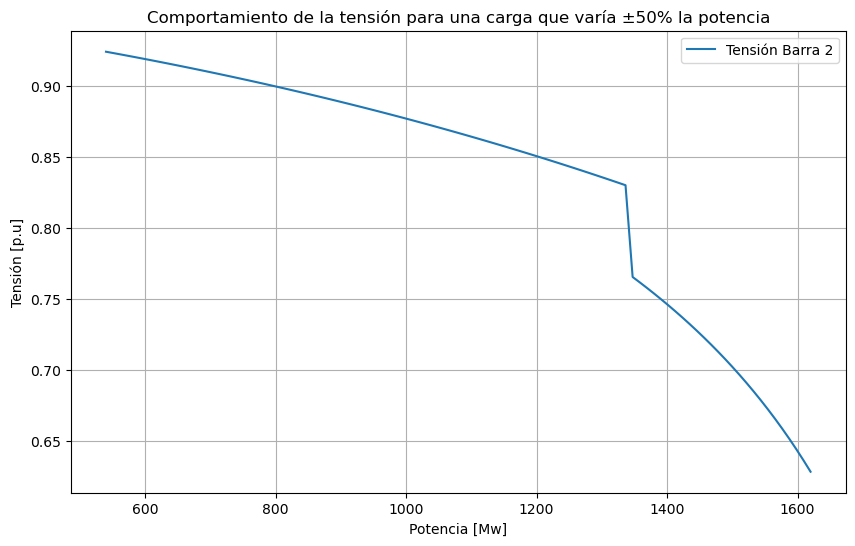

In [7]:
import pandapower as pp
import pandapower.plotting.plotly as plotly
import random
import matplotlib.pyplot as plt
import numpy

net = pp.create_empty_network()
bus1 = pp.create_bus(net, name="Barra 1", vn_kv=500, type="b")
bus2 = pp.create_bus(net, name="Barra 2", vn_kv=500, type="b")

# mostrar tabla con barras
print(net.bus)

# Creando un tipo de línea 
linea_a = {"r_ohm_per_km": 0.02, "x_ohm_per_km": 0.115, "c_nf_per_km": 19.1, "max_i_ka": 1}
pp.create_std_type(net, name="linea_a", data=linea_a, element="line")
pp.available_std_types(net, element="line")

# Línea
line1 = pp.create_line(net, from_bus=bus1, to_bus=bus2, length_km=500, std_type="linea_a", name="Línea 1")

print(net.line)


# Añadir una fuente externa
pp.create_ext_grid(net, bus1, vm_pu=1, name="Grid Connection")

# Carga
pp.create_load(net, bus2, p_mw=1080, q_mvar=523.03, name="Carga")

#------------Variando la carga------------------ 


# Potencia inicial
p_in = 1200*0.9  # en Mw, 1200 MVA.

# Crear un rango de potencias que represente el cambio de ±50%
p_range = numpy.linspace(p_in*0.5, p_in*1.5, num=100)

# Lista para guardar las tensiones
voltages = []

# Para cada potencia en el rango
for p in p_range:
    # Actualizar la carga en la red
    net.load.loc[0, 'p_mw'] = p
    
    # Ejecutar una simulación de flujo de potencia
    pp.runpp(net, tolerance_mva=100, max_iteration=100)
    
    # Guardar la tensión en el bus de la carga
    voltages.append(net.res_bus.vm_pu[bus2])

# Graficar la tensión en función de la potencia
plt.figure(figsize=(10, 6))
plt.plot(p_range, voltages, label='Tensión Barra 2')
plt.xlabel('Potencia [Mw]')
plt.ylabel('Tensión [p.u]')
plt.title('Comportamiento de la tensión para una carga que varía ±50% la potencia')
plt.legend()
plt.grid(True)
plt.show()


#### Justificación teórica

## 3.b) Compensación

In [50]:
import numpy as np 
from sympy import symbols, Eq, csolve

#---------Párametros obtenidos previamente---------
A = (0.97741975+0.003926999999999999j)
B = (9.849465+57.080301875j)
C = (-1.0280886000000084e-06+0.00077948849055j)
D = (0.97741975+0.003926999999999999j)
#-------------------Datos--------------------------
Sc= 1200*10**6
fp=0.9
Vs= (500*10**3)/np.sqrt(3)
#---------------Formulación----------------------
Vr=Vs
Ir= (Sc/fp)/Vr
Vs= (B*Y+A)*Vr+B*Ir 

Y = symbols('Y')

eq = Eq(abs(Vs), abs((B * Y + A) * Vr + B * Ir))

soluciones = csolve(eq, Y)
Yc = soluciones[0]

print("Yc =", Yc)

ImportError: cannot import name 'csolve' from 'sympy' (c:\Users\pedro\anaconda3\Lib\site-packages\sympy\__init__.py)

## 3.c) Pérdidas de línea para rango de pot deman y rango de comp 

### Figura b
<div>
<img src="Figura b.png" width="500"/>
</div>


## 4.a) Identificar líneas saturadas o fuera de norma

### Gráfico Estado líneas

### Método para resolver problema 

## 4.b) Identificar si las Tensiones de las barras estan fuera de norma según ambos escenarios 

### Estado Normal

### Estado Alerta

## 4.c) 

## 4.d)

## 4.e)

## 4.f)

## 4.g)